In [3]:
from importlib import reload
import evosim
reload(evosim)

<module 'evosim' from '/home/mep/Repos/evosim/evosim.py'>

# Six possible genotypes

We will consider a population of N=10<sup>9</sup> individual organisms, each of which has a certain genotype.

There are two possible alleles at the "major locus”: *A* and *a*. The “major locus” means the locus under selection. The alleles A and a will have different fitnesses.

There are three possible alleles at the "mutator locus": *M<sub>2</sub>*, *M<sub>3</sub>*, *M<sub>4</sub>*. There is no direct selection on the mutator locus, but we will see there is a kind of “long-term” selection on it, *which is the point of this exercise*.

This makes a total of 2 * 3 = 6 possible genotypes:

<img src="6genotypes.png" alt="drawing" width="300"/>


# Selection
There will be two environments in our model: at any generation the current "environmental state” is either *A* of *a*. This state will fluctuate over time on a schedule that I will explain below.

Environment *A* favors major allele *A*, and environment *a* favors major allele *a*.

Organisms holding the allele at the major locus that matches the state of the environment will produce more offspring than organisms with the other allele: they are more fit.

Specifically, given a “selection coefficient” *s*, the matching (fitter) organisms produce 1*s* times more offspring than the less fit organisms. This means that the fitter organisms will increase in relative number. (We set *s* to 0.1 in all the examples below.)

# Mutation
The alleles M2, M3, M4 at the mutator locus produce mutation rates in the major locus of 10-2, 10-3, 10-4, respectively. The rate is symmetric, from A to a, or from a to A.

For example, at each generation, an individual with genotype (A, M2) produces offspring that are 99% (A, M2), and 1% (a, M2); that is, the A mutates to a in 1 out of 102 offspring.

Similarly, an individual with genotype (A, M4) produces offspring that are 99.99% (A, M4), and 0.01% (a, M4);  that is, the A mutates to a in 1 out of 104 offspring.

In the other direction, for example, an individual with genotype (a, M2) produces offspring that are 99% (a, M2), and 1% (A, M2); that is, the a mutates to A in 1 out of 102 offspring.

The mutator locus itself never mutates. That means that all descendants of an individual possessing an M2 at the mutator locus will always possess an M2 (and likewise for M3, M4). This constraint in our particular experimental setup makes the mutator locus a convenient marker of clade identity. We can speak of the M2 clade as being founded by all the M2 individuals at generation 0, and all of its members will always possess an M2 forever.


# Each generation of evolution
At each generation, we will first apply **selection** to determine the number of offspring that each individual organism will have (which depends on its major allele and the state of the environment); and then we will apply **mutation** (which depends on its mutator allele) to determine the proportions of each of the major alleles (either A or a) that will be produced in its offspring.

# Learning Goal
The mutator locus does not affect organismal fitness: it is not visible to selection over one generation. Individual organisms are selected depending only on the allele they hold at the major locus, and whether it matches the environmental state. Nonetheless, we will see that there is effectively “long-term selection” on the mutator locus. That is, the mutator locus does become visible to long-term selection, because of the distribution of offspring it generates. Even though it is invisible to selection in individual organisms over one generation, it nonetheless affects the multi-generation clade fitness.

gen:0 epoch:0
swap environments
 pop 0:
  clade m2: nA:       0.00 nB:333344401.00, (n:333344401.00)             mu:1.00e-02
  clade m3: nA:       0.00 nB:333330851.00, (n:333330851.00)             mu:1.00e-03
  clade m4: nA:       0.00 nB:333370449.00, (n:333370449.00)             mu:1.00e-04
  sumR: 1000045701.00
  sumN: 1000045701.00
  env: idx:0 sA:0.1 sB:0.0


sT:10000.0
mode: mutation
pop 0 env: [(0, 0)]


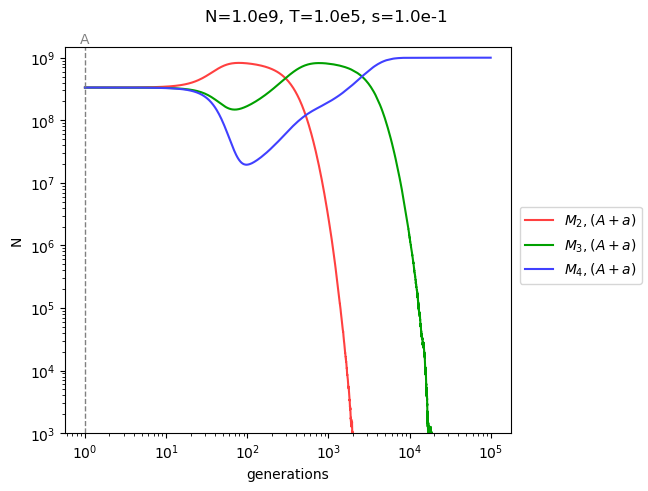

In [5]:
evosim.main()